In [1]:
%matplotlib inline

import cv2 # The OpenCV library; install using `pip install opencv-contrib-python`
import numpy as np # Helpful when working with arrays; install using `pip install numpy`
from matplotlib import pyplot as plt # Good for graphing; install using `pip install matplotlib`
from matplotlib import image as image
import easygui # An easy-to-use file-picker; pip install easygui (mac not supported)

In [2]:
# get background subtractor
sub_type = 'KNN' # 'MOG2'
if sub_type == "MOG2":
    backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=16, detectShadows=True)
    # backSub.setShadowThreshold(0.75)
else:
    backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=1000, detectShadows=True)

Text(0.5, 1.0, 'KNN Foreground Mask after 5 frames')

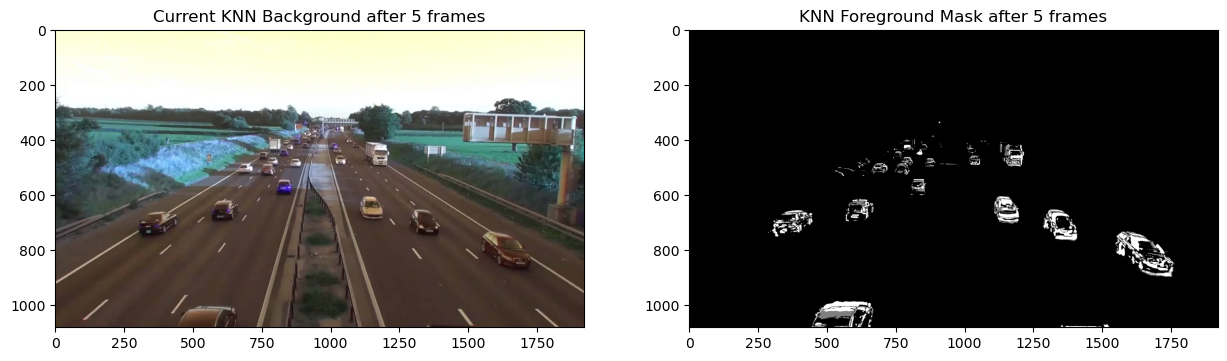

In [3]:
video = cv2.VideoCapture("Images/traffic.mp4")

image_paths = []

# read the first 5 frames
for i in range(5):
    ret, frame = video.read()
    fg_mask = backSub.apply(frame)


# display
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(backSub.getBackgroundImage())
ax[0].set_title(f"Current {sub_type} Background after 5 frames")
ax[1].imshow(fg_mask, cmap='gray') 
ax[1].set_title(f"{sub_type} Foreground Mask after 5 frames")

In [4]:
def get_motion_mask(fg_mask, min_thresh=0, kernel=np.array((9,9), dtype=np.uint8)):
    """ Obtains image mask
        Inputs: 
            fg_mask - foreground mask
            kernel - kernel for Morphological Operations
        Outputs: 
            mask - Thresholded mask for moving pixels
        """
    _, thresh = cv2.threshold(fg_mask,min_thresh,255,cv2.THRESH_BINARY)
    motion_mask = cv2.medianBlur(thresh, 3)
    
    # morphological operations
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return motion_mask

def get_contour_detections(mask, thresh=400):
    # get mask contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)
    detections = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        area = w*h
        if area > thresh: 
            detections.append([x,y,x+w,y+h, area])

    return np.array(detections)

def remove_contained_bboxes(boxes):
    check_array = np.array([True, True, False, False])
    keep = list(range(0, len(boxes)))
    for i in keep: # range(0, len(bboxes)):
        for j in range(0, len(boxes)):
            # check if box j is completely contained in box i
            if np.all((np.array(boxes[j]) >= np.array(boxes[i])) == check_array):
                try:
                    keep.remove(j)
                except ValueError:
                    continue
    return keep


def non_max_suppression(boxes, scores, threshold=1e-1):
    # Sort the boxes by score in descending order
    boxes = boxes[np.argsort(scores)[::-1]]

    # remove all contained bounding boxes and get ordered index
    order = remove_contained_bboxes(boxes)

    keep = []
    while order:
        i = order.pop(0)
        keep.append(i)
        for j in order:
            # Calculate the IoU between the two boxes
            intersection = max(0, min(boxes[i][2], boxes[j][2]) - max(boxes[i][0], boxes[j][0])) * \
                           max(0, min(boxes[i][3], boxes[j][3]) - max(boxes[i][1], boxes[j][1]))
            union = (boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1]) + \
                    (boxes[j][2] - boxes[j][0]) * (boxes[j][3] - boxes[j][1]) - intersection
            iou = intersection / union

            # Remove boxes with IoU greater than the threshold
            if iou > threshold:
                order.remove(j)
                
    return boxes[keep]

def get_detections(backSub, frame, bbox_thresh=100, nms_thresh=0.1, kernel=np.array((9,9), dtype=np.uint8)):
    """ Main function to get detections via Frame Differencing
        Inputs:
            backSub - Background Subtraction Model
            frame - Current BGR Frame
            bbox_thresh - Minimum threshold area for declaring a bounding box
            nms_thresh - IOU threshold for computing Non-Maximal Supression
            kernel - kernel for morphological operations on motion mask
        Outputs:
            detections - list with bounding box locations of all detections
                bounding boxes are in the form of: (xmin, ymin, xmax, ymax)
        """
    # Update Background Model and get foreground mask
    fg_mask = backSub.apply(frame)

    # get clean motion mask
    motion_mask = get_motion_mask(fg_mask, kernel=kernel)

    # get initially proposed detections from contours
    detections = get_contour_detections(motion_mask, bbox_thresh)

    # Check if detections are not empty and have the expected shape
    if detections is None or len(detections) == 0:
        return np.array([])  # Return an empty array if there are no detections
    
    # Make sure detections is a 2D array
    detections = np.atleast_2d(detections)
    # separate bboxes and scores
    bboxes = detections[:, :4]
    scores = detections[:, -1]

    # perform Non-Maximal Supression on initial detections
    return non_max_suppression(bboxes, scores, nms_thresh)

In [5]:
def initialize_tracker(frame, detections):
    # Initialize tracker with the largest detected bounding box (assume it's the truck)
    global tracker, tracking
    if len(detections) > 0:
        largest_box = max(detections, key=lambda x: x[-1])  # Choose the box with the largest area
        x1, y1, x2, y2 = largest_box[:4]
        tracker.init(frame, (x1, y1, x2 - x1, y2 - y1))  # Initialize tracker
        tracking = True  # Set the tracking flag

def draw_path(frame, path, color=(0, 0, 255), thickness=2):
    """ Draws the path of the object """
    for i in range(1, len(path)):
        cv2.line(frame, path[i - 1], path[i], color, thickness)

Text(0.5, 1.0, 'KNN Foreground Mask after 5 frames')

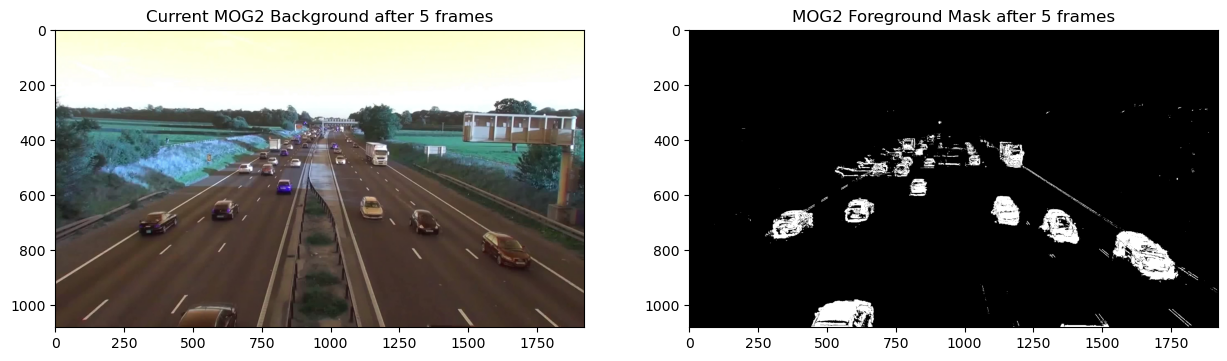

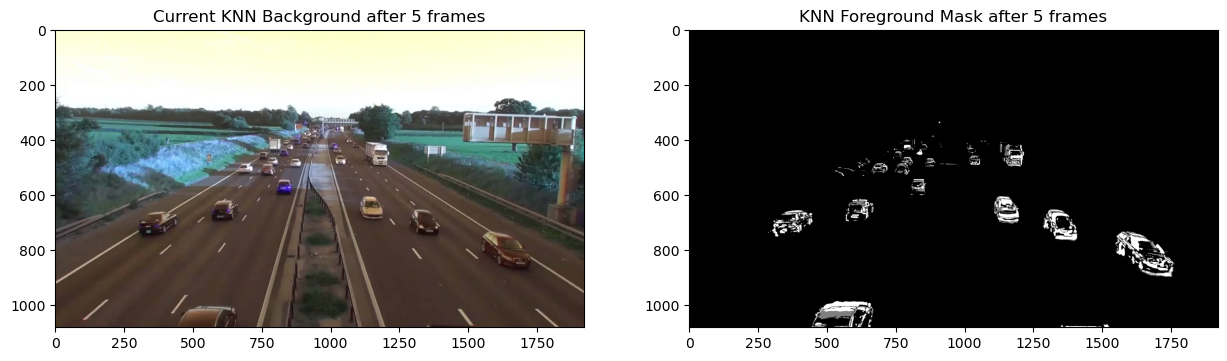

In [6]:
kernel=np.array((9,9), dtype=np.uint8)


sub_type = 'MOG2' # 'KNN'
if sub_type == "MOG2":
    backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=16, detectShadows=True)
    backSub.setShadowThreshold(0.5)
else:
    backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=1000, detectShadows=True)


video = cv2.VideoCapture("Images/traffic.mp4")

# read the first 5 frames
for i in range(5):
    ret, frame = video.read()
    fg_mask = backSub.apply(frame)

# display
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(backSub.getBackgroundImage())
ax[0].set_title(f"Current {sub_type} Background after 5 frames")
ax[1].imshow(fg_mask, cmap='gray')
ax[1].set_title(f"{sub_type} Foreground Mask after 5 frames")

# get detections
detections = get_detections(backSub, frame, bbox_thresh=100, nms_thresh=0.1, kernel=kernel)


sub_type = 'KNN' # 'KNN'
if sub_type == "MOG2":
    backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=16, detectShadows=True)
    backSub.setShadowThreshold(0.5)
else:
    backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=1000, detectShadows=True)

video = cv2.VideoCapture("Images/traffic.mp4")

# read the first 5 frames
for i in range(5):
    ret, frame = video.read()
    fg_mask = backSub.apply(frame)
    
# display
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(backSub.getBackgroundImage())
ax[0].set_title(f"Current {sub_type} Background after 5 frames")
ax[1].imshow(fg_mask, cmap='gray')
ax[1].set_title(f"{sub_type} Foreground Mask after 5 frames")




In [7]:
# KNN

video = cv2.VideoCapture("Images/traffic.mp4")

sub_type = 'KNN'
if sub_type == "MOG2":
    backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=16, detectShadows=True)
    backSub.setShadowThreshold(0.5)
else:
    backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=1000, detectShadows=True)
    
while True:
    ret, frame = video.read()
    if frame is None:
        break
    detections = get_detections(backSub, frame, bbox_thresh=100, nms_thresh=0.1, kernel=kernel)
    
    for x1, y1, x2, y2 in detections:
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.imshow("Detections", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()



In [8]:
# MOG2 (MOG2 picks up a lot more and is more sensitive to noise)

video = cv2.VideoCapture("Images/traffic.mp4")

sub_type = 'MOG2'
if sub_type == "MOG2":
    backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=16, detectShadows=True)
    backSub.setShadowThreshold(0.5)
else:
    backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=1000, detectShadows=True)
    
while True:
    ret, frame = video.read()
    if frame is None:
        break
    detections = get_detections(backSub, frame, bbox_thresh=100, nms_thresh=0.1, kernel=kernel)
    for x1, y1, x2, y2 in detections:
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.imshow("Detections", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()



In [9]:
# MOG2 (MOG2 picks up a lot more and is more sensitive to noise)

video = cv2.VideoCapture("Images/traffic.mp4")

kernel=np.array((9,9), dtype=np.uint8)

sub_type = 'MOG2'
if sub_type == "MOG2":
    backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=16, detectShadows=True)
    backSub.setShadowThreshold(0.5)
else:
    backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=1000, detectShadows=True)
    
while True:
    ret, frame = video.read()
    if frame is None:
        break
    
    
    # Get mask
    fg_mask = backSub.apply(frame)

    # get clean motion mask
    motion_mask = get_motion_mask(fg_mask, kernel=kernel)
    
    cv2.imshow("Detections", motion_mask)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()



In [10]:

video = cv2.VideoCapture("Images/traffic.mp4")

kernel=np.array((9,9), dtype=np.uint8)

sub_type = 'MOG2'
if sub_type == "MOG2":
    backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=16, detectShadows=True)
    backSub.setShadowThreshold(0.5)
else:
    backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=1000, detectShadows=True)
    
while True:
    ret, frame = video.read()
    if frame is None:
        break
    
    
    # Get mask
    fg_mask = backSub.apply(frame)

    # get clean motion mask
    _, thresh = cv2.threshold(fg_mask,0,255,cv2.THRESH_BINARY)
    motion_mask = cv2.medianBlur(thresh, 3)
    
    # morphological operations
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    
   
    
    cv2.imshow("Detections", motion_mask)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()



In [18]:
import cv2
import numpy as np

# Open the video file
video = cv2.VideoCapture("Images/traffic.mp4")

# Create a background subtractor
kernel = np.ones((9, 9), np.uint8)
sub_type = 'KNN'
if sub_type == "MOG2":
    backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=16, detectShadows=True)
    backSub.setShadowThreshold(0.5)
else:
    backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=1000, detectShadows=True)

# Initialize vehicle tracking data
vehicle_tracks = {}  # Store vehicle ID and their paths
vehicle_id_count = 0  # Unique ID for each vehicle

def merge_boxes(boxes, threshold=30):
    """ Merge nearby bounding boxes """
    merged_boxes = []
    for box in boxes:
        x, y, w, h = box
        merged = False
        for i, mbox in enumerate(merged_boxes):
            mx, my, mw, mh = mbox
            # Check if the boxes are close enough to merge
            if (abs(mx - x) < threshold and abs(my - y) < threshold):
                new_x = min(mx, x)
                new_y = min(my, y)
                new_w = max(mx + mw, x + w) - new_x
                new_h = max(my + mh, y + h) - new_y
                merged_boxes[i] = (new_x, new_y, new_w, new_h)
                merged = True
                break
        if not merged:
            merged_boxes.append((x, y, w, h))
    return merged_boxes

def assign_ids_to_boxes(boxes, vehicle_tracks, vehicle_id_count, threshold=50):
    """ Assign unique IDs to detected vehicles based on proximity to previous detections """
    updated_tracks = {}
    
    for box in boxes:
        x, y, w, h = box
        center = (x + w // 2, y + h // 2)
        assigned = False
        
        # Check if this box matches an existing vehicle track
        for vid, path in vehicle_tracks.items():
            # Compare the distance from the current center to the last known position of each tracked vehicle
            if np.linalg.norm(np.array(center) - np.array(path[-1])) < threshold:
                updated_tracks[vid] = path + [center]
                assigned = True
                break

        if not assigned:
            # If no match was found, assign a new vehicle ID
            updated_tracks[vehicle_id_count] = [center]
            vehicle_id_count += 1

    return updated_tracks, vehicle_id_count

while True:
    ret, frame = video.read()
    if frame is None:
        break

    # Apply background subtraction to get the foreground mask
    fg_mask = backSub.apply(frame)

    # Clean the motion mask
    _, thresh = cv2.threshold(fg_mask, 200, 255, cv2.THRESH_BINARY)
    motion_mask = cv2.medianBlur(thresh, 3)

    # Apply morphological operations to reduce noise
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Find contours to get the bounding boxes
    contours, _ = cv2.findContours(motion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = [cv2.boundingRect(cnt) for cnt in contours]

    # Merge nearby bounding boxes
    boxes = merge_boxes(boxes)

    # Assign IDs to bounding boxes and track their paths
    vehicle_tracks, vehicle_id_count = assign_ids_to_boxes(boxes, vehicle_tracks, vehicle_id_count)

    # Draw bounding boxes and the paths of each vehicle
    for vid, path in vehicle_tracks.items():
        # Draw the bounding box for the last known position
        if len(path) > 0:
            last_position = path[-1]
            # Find the bounding box associated with this vehicle's last position
            for box in boxes:
                x, y, w, h = box
                center = (x + w // 2, y + h // 2)
                if np.linalg.norm(np.array(center) - np.array(last_position)) < 10:
                    # Draw the bounding box
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    break

        # Draw the path for this vehicle
        for i in range(1, len(path)):
            if path[i - 1] is None or path[i] is None:
                continue
            # Draw the path line in the output frame
            cv2.line(frame, path[i - 1], path[i], (0, 0, 255), 2)

    # Show the frame with detections and paths
    cv2.imshow("Detections", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
video.release()
cv2.destroyAllWindows()


In [24]:
import cv2
import numpy as np

# Video capture
video = cv2.VideoCapture("Images/traffic.mp4")
fps = video.get(cv2.CAP_PROP_FPS)

# Line positions
start1, end1 = (566, 455), (1166, 455)  # First line
start2, end2 = (785, 391), (1085, 391)  # Second line
color = (0, 0, 255)
thickness = 3

# Calculate the distance between lines (in meters)
DISTANCE_BETWEEN_LINES = 100  # meters

# For background subtraction
sub_type = 'KNN'
if sub_type == "MOG2":
    backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=16, detectShadows=True)
    backSub.setShadowThreshold(0.5)
else:
    backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=1000, detectShadows=True)

# Tracking variables
vehicle_tracks = {}  # Store vehicle paths
vehicle_id_count = 1  # Start IDs from 1
vehicle_data = {}  # Store timing data for speed calculation

def assign_ids_to_boxes(boxes, vehicle_tracks, vehicle_id_count, threshold=50):
    """ Assign unique IDs to detected vehicles based on proximity to previous detections """
    updated_tracks = {}
   
    for box in boxes:
        x, y, w, h = box
        center = (x + w // 2, y + h // 2)
        assigned = False
       
        # Check if this box matches an existing vehicle track
        for vid, path in vehicle_tracks.items():
            # Compare the distance from the current center to the last known position of each tracked vehicle
            if np.linalg.norm(np.array(center) - np.array(path[-1])) < threshold:
                updated_tracks[vid] = path + [center]
                assigned = True
                break
        if not assigned:
            # If no match was found, assign a new vehicle ID
            updated_tracks[vehicle_id_count] = [center]
            vehicle_id_count += 1
    return updated_tracks, vehicle_id_count

def get_detections(backSub, frame, bbox_thresh=100, nms_thresh=0.1):
    fg_mask = backSub.apply(frame)
    _, thresh = cv2.threshold(fg_mask, 244, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    detections = []
    for contour in contours:
        if cv2.contourArea(contour) > bbox_thresh:
            x, y, w, h = cv2.boundingRect(contour)
            detections.append((x, y, w, h))
    return detections

def check_line_crossing(y, y_line, tolerance=5):
    """Checks if a bounding box edge (y) crosses a specific line (y_line)."""
    return abs(y - y_line) <= tolerance

def calculate_speed(time_diff, distance):
    """Calculate speed in km/h"""
    if time_diff <= 0:
        return 0
    speed = (distance / time_diff) * 3.6  # Convert m/s to km/h
    return speed

def draw_vehicle_id(frame, x, y, vehicle_id, speed=None):
    """Draw vehicle ID and speed on the frame"""
    text = f"ID: {vehicle_id}"
    if speed is not None:
        text += f" {speed:.1f}km/h"
    cv2.putText(frame, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

while True:
    ret, frame = video.read()
    if not ret:
        break

    # Draw the lines on the frame
    cv2.line(frame, start1, end1, color, thickness)
    cv2.line(frame, start2, end2, color, thickness)

    # Get the current timestamp
    current_time = video.get(cv2.CAP_PROP_POS_MSEC)

    # Detect moving objects
    detections = get_detections(backSub, frame, bbox_thresh=100)

    # Assign IDs to detected vehicles
    vehicle_tracks, vehicle_id_count = assign_ids_to_boxes(detections, vehicle_tracks, vehicle_id_count)

    # Process each detection with its assigned ID
    for (x, y, w, h) in detections:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        center = (x + w // 2, y + h // 2)
        
        # Find the ID for this detection
        current_id = None
        for vid, path in vehicle_tracks.items():
            if path[-1] == center:
                current_id = vid
                break
        
        if current_id is not None:
            # Check for line crossings
            if check_line_crossing(y + h, start1[1]):
                if current_id not in vehicle_data:
                    vehicle_data[current_id] = {
                        'first_crossing': current_time,
                        'second_crossing': None,
                        'direction': 'down'
                    }
            
            if check_line_crossing(y + h, start2[1]):
                if current_id not in vehicle_data:
                    vehicle_data[current_id] = {
                        'first_crossing': current_time,
                        'second_crossing': None,
                        'direction': 'up'
                    }
                elif vehicle_data[current_id].get('second_crossing') is None:
                    vehicle_data[current_id]['second_crossing'] = current_time

            # Calculate and display speed if both crossings are recorded
            if current_id in vehicle_data:
                data = vehicle_data[current_id]
                if data['first_crossing'] is not None and data['second_crossing'] is not None:
                    time_diff = abs(data['second_crossing'] - data['first_crossing']) / 1000.0
                    speed = calculate_speed(time_diff, DISTANCE_BETWEEN_LINES)
                    draw_vehicle_id(frame, x, y, current_id, speed)
                else:
                    draw_vehicle_id(frame, x, y, current_id)

    cv2.imshow("Detections", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Print final results
print("\nVehicle Speed Results:")
for vid, data in vehicle_data.items():
    if data['first_crossing'] is not None and data['second_crossing'] is not None:
        time_diff = abs(data['second_crossing'] - data['first_crossing']) / 1000.0
        speed = calculate_speed(time_diff, DISTANCE_BETWEEN_LINES)
        direction = "Northbound" if data['direction'] == 'up' else "Southbound"
        print(f"Vehicle {vid} ({direction}): {speed:.1f} km/h")

video.release()
cv2.destroyAllWindows()


Vehicle Speed Results:
Vehicle 463 (Northbound): 10800.0 km/h
Vehicle 537 (Northbound): 10800.0 km/h
Vehicle 578 (Northbound): 10800.0 km/h
Vehicle 534 (Northbound): 10800.0 km/h
Vehicle 605 (Southbound): 5400.0 km/h
Vehicle 222 (Southbound): 1200.0 km/h
Vehicle 611 (Southbound): 5400.0 km/h
Vehicle 619 (Southbound): 5400.0 km/h
Vehicle 627 (Southbound): 3600.0 km/h
Vehicle 633 (Southbound): 5400.0 km/h
Vehicle 643 (Southbound): 5400.0 km/h
Vehicle 650 (Southbound): 5400.0 km/h
Vehicle 658 (Southbound): 5400.0 km/h
Vehicle 665 (Southbound): 5400.0 km/h
Vehicle 674 (Northbound): 10800.0 km/h
Vehicle 679 (Northbound): 10800.0 km/h
Vehicle 686 (Northbound): 10800.0 km/h
Vehicle 692 (Northbound): 10800.0 km/h
Vehicle 698 (Northbound): 10800.0 km/h
Vehicle 709 (Northbound): 10800.0 km/h
Vehicle 717 (Northbound): 10800.0 km/h
Vehicle 726 (Northbound): 10800.0 km/h
Vehicle 735 (Northbound): 10800.0 km/h
Vehicle 741 (Northbound): 10800.0 km/h
Vehicle 744 (Northbound): 10800.0 km/h
Vehicle 748